In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,Passengers
0,15-01-1949,112
1,15-02-1949,118
2,15-03-1949,132
3,15-04-1949,129
4,15-05-1949,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
df = df.set_index('Month')
df.head()

,Passengers
Month,
15-01-1949,112
15-02-1949,118
15-03-1949,132
15-04-1949,129
15-05-1949,121


### Visualize the time series

**Check for trend, seasionality or random patterens.**

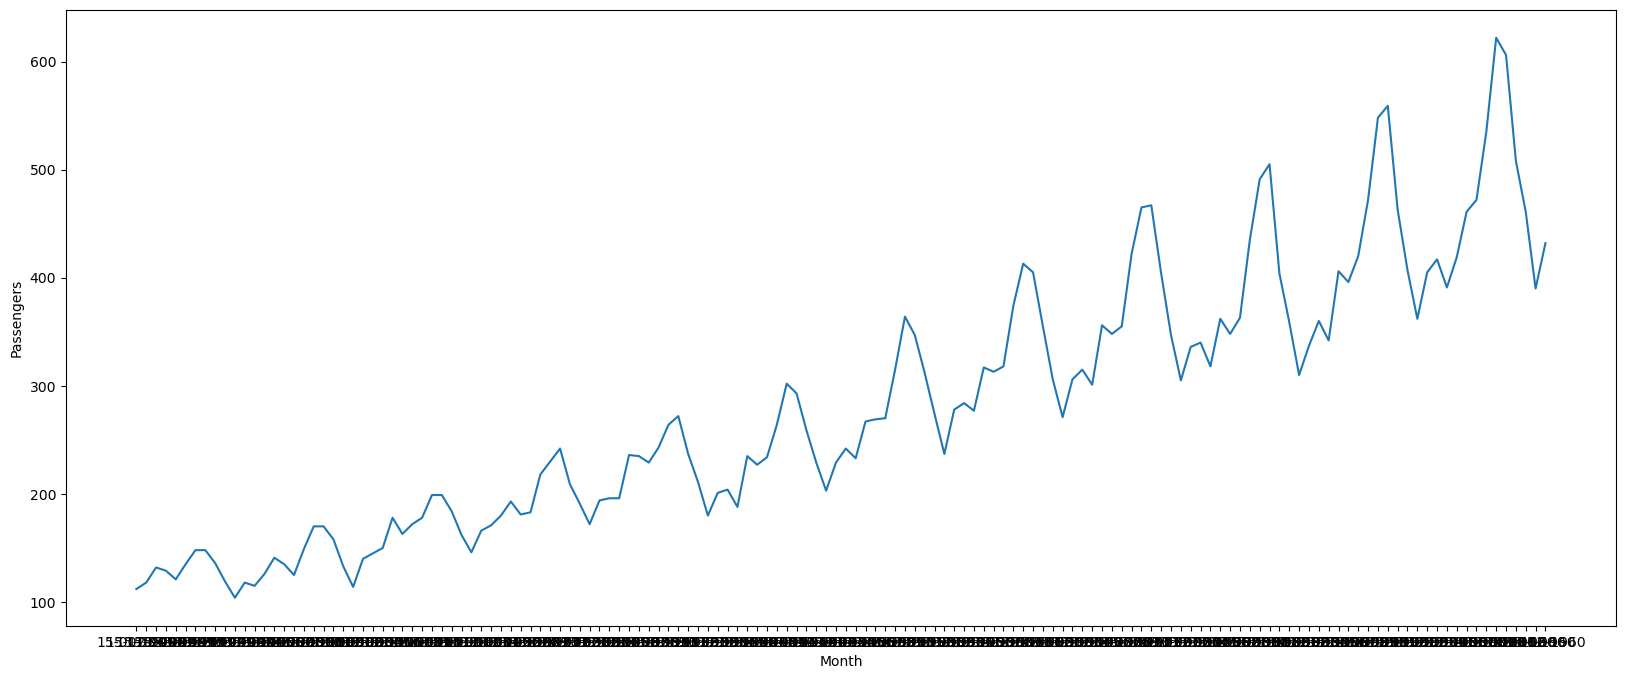

In [5]:
plt.figure(figsize=(20,8))
sns.lineplot(x=df.index,y=df['Passengers'])
plt.show()

### Check for Stationarity

**Method-1: Rolling Statistics**

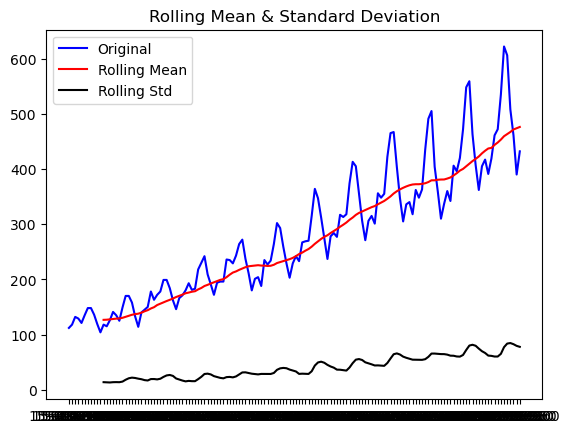

In [6]:
# Determining rolling statistics
rolmean = df['Passengers'].rolling(window=12).mean()
rolstd = df['Passengers'].rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(df['Passengers'], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black',label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

### Method-2: Augmented Dicky Fuller Test
- for the ADF Test
  + H0: Data is non-stationary
  + H1: Data is stationary
- Based on pvalue, we will accept or reject H0 (if p-value < 5% reject null hypothesis)


In [7]:
from statsmodels.tsa.stattools import adfuller
adfuller_result = adfuller(df['Passengers'])
adfuller_result

(0.8153688792060511,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [8]:
print('P-Value:', adfuller_result[1])

P-Value: 0.991880243437641


**The Time Series is not stationary.**

### Now we have to convert the stationary data to stationary data
- Differencing

In [9]:
# Apply differencing
diff = df['Passengers'] - df['Passengers'].shift(2)

diff.dropna(inplace=True)

# Applying ADF Test
adfuller_result = adfuller(diff)
print('P-value of adf test:', adfuller_result[1])

P-value of adf test: 0.03862975767698981


In [10]:
diff.head()

Month
15-03-1949    20.0
15-04-1949    11.0
15-05-1949   -11.0
15-06-1949     6.0
15-07-1949    27.0
Name: Passengers, dtype: float64

**Now the timeseries is stationary.**

### Step-4: Plot ACF/PACF and find p,d,q parameters

In [11]:
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
fig1 = sm.graphics.tsa.plot_acf(diff,lags=40)
fig2 = sm.graphics.tsa.plot_pacf(diff,lags=40)

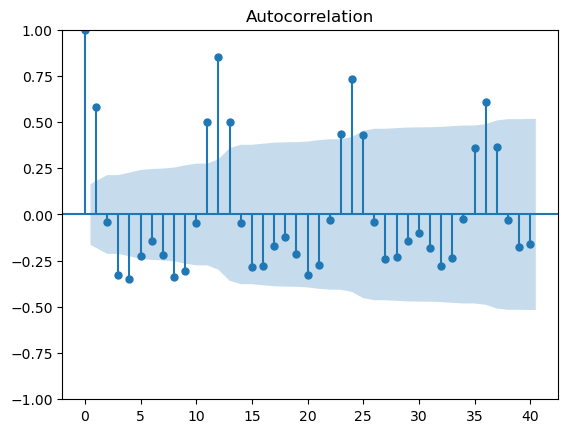

In [12]:
fig1

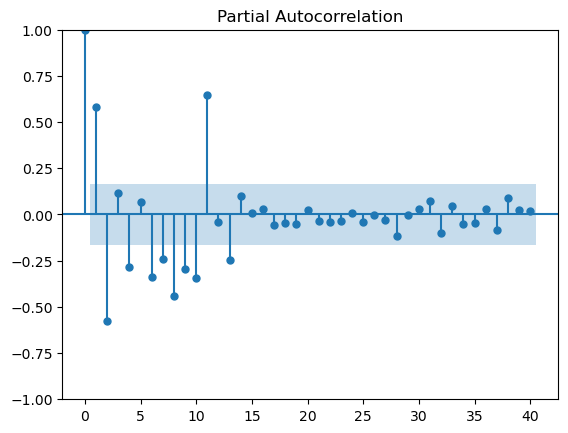

In [13]:
fig2

**From ACF curve, optimal value of q in the ARIMA model must be 11.**

**From PACF curve, optimal value of p in the ARIMA model is 12.**

### *Train-Test Split*
**Split the data into train (80%) & test (20%)**
- For time series data, we have use first 80% records for training & next 20% of records for testing.
- here 80%= 0.8*142=114 records, so first 114 records we have to use for training.

**Note: We should not apply train-test split function, because it divides the data randomly.**

In [14]:
y_train = diff[:114]
y_test = diff[114:]

## *Build ARIMA Model*
**ARIMA Model is build by using p,d,q values**
- p is AR value (determined from PACF plot)
- d is integration (hyperparameter tuning)
- q is MA value (determined from ACF plot)

**Modeling**

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
# AR modelling
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(diff, order=(11,0,0))
ARIMA = model.fit()

# prediction & evaluation on train data
ypred_train = ARIMA.predict(start=y_train.index[0], end=y_train.index[-1])

from sklearn.metrics import r2_score
print('Train R2 AR model:',r2_score(ypred_train,y_train))

# Prediction and evaluation on test data
ypred_test = ARIMA.predict(start=y_test.index[0], end=y_test.index[-1])
print('Test R2 AR model:',r2_score(ypred_test,y_test))

Train R2 AR model: 0.9354944641300962
Test R2 AR model: 0.9551178376135875


In [19]:
# MA modelling (q)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(diff, order=(0,0,12))
ARIMA = model.fit()

# prediction & evaluation on train data
ypred_train = ARIMA.predict(start=y_train.index[0], end=y_train.index[-1])

from sklearn.metrics import r2_score
print('Train R2 of MA model:',r2_score(ypred_train,y_train))

# Prediction and evaluation on test data
ypred_test = ARIMA.predict(start=y_test.index[0], end=y_test.index[-1])
print('Test R2 of MA model:',r2_score(ypred_test,y_test))

Train R2 of MA model: 0.839765057236301
Test R2 of MA model: 0.898287873624741


In [20]:
# ARMA modelling (p,q)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(diff, order=(11,0,12))
ARIMA = model.fit()

# prediction & evaluation on train data
ypred_train = ARIMA.predict(start=y_train.index[0], end=y_train.index[-1])

from sklearn.metrics import r2_score
print('Train R2 of ARMA model:',r2_score(ypred_train,y_train))

# Prediction and evaluation on test data
ypred_test = ARIMA.predict(start=y_test.index[0], end=y_test.index[-1])
print('Test R2 of ARMA model:',r2_score(ypred_test,y_test))

Train R2 of ARMA model: 0.9381794823750856
Test R2 of ARMA model: 0.9658007142567228


In [26]:
# ARIMA modelling (p,d,q)
# d is hyper parameter
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(diff, order=(11,1,12))
ARIMA = model.fit()

# prediction & evaluation on train data
ypred_train = ARIMA.predict(start=y_train.index[0], end=y_train.index[-1])

from sklearn.metrics import r2_score
print('Train R2 of ARIMA model:',r2_score(ypred_train,y_train))

# Prediction and evaluation on test data
ypred_test = ARIMA.predict(start=y_test.index[0], end=y_test.index[-1])
print('Test R2 of ARIMA model:',r2_score(ypred_test,y_test))

Train R2 of ARIMA model: 0.9278177138878592
Test R2 of ARIMA model: 0.9650419905577505


- **Here, ARIMA model is not performing well, because there is seasonality in the given data.**

## *Build SARIMAX Model*
**Whenever, there is seasonality in the given data, apply SARIMAX**

**SARIMAX Model is build by using p,d,q,s values**
- p is AR value (determined from PACF plot)
- d is integration (hyper parameter tuning)
- q is MA value (determined from ACF plot)
- s is seasonality value (determined from line plot)

**Modeling**

In [27]:
# modelling
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(diff,seasonal_order=(11,0,12,12))
SARIMAX = model.fit()

# prediction
ypred_train = SARIMAX.predict(start=y_train.index[0], end=y_train.index[-1])
ypred_test = SARIMAX.predict(start=y_test.index[0], end=y_test.index[-1])

# evaluation
print('Train R2 of SARIMAX model:',r2_score(ypred_train,y_train))
print('Test R2 of SARIMAX model:',r2_score(ypred_test,y_test))

Train R2 of SARIMAX model: 0.8962800315195758
Test R2 of SARIMAX model: 0.9495934653820485
